# Producing a classifier to determine whether a patient has Heart Disease

## Introduction:
Heart disease, also known as coronary artery disease, is a common cardiovascular ailment that affects the main blood arteries that supply the heart muscle. Plaques, or accumulations of cholesterol within the heart arteries, are usually the cause of this condition. This accumulation, known as atherosclerosis, reduces blood flow to the heart and other parts of the body, which may cause a heart attack, angina (chest discomfort), or stroke. Elevated blood pressure, elevated low-density lipoprotein (LDL) cholesterol, diabetes, tobacco use, obesity, a poor diet, and insufficient physical exercise are some of the main risk factors for heart disease and stroke.

With this project, we wanted to determine the accuracy of the classification of the heart disease prognosis given specific predictors from the given data set. However, note that we additionally also figured out the recall and precision for a better understanding of our work and results. In particular we looked to find out if an undiagnosed patient was likely to have heart disease given age, cholesterol, resting blood pressure, maximum heart rate, and ST depression induced by exercise relative to rest (where ‘ST’ relates to positions on the ECG plot)

We chose to work with the Hungary data set from the Heart Disease, and given the variables mentioned above, make classifications on undiagnosed patients. The reason for this was that the other datasets within heart disease had either lots of missing data or not enough viable information in general to be a good source for classification, as to why we chose the Hungary data set from Heart Disease. 

## Methods and Results: 

In [94]:
library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)
library(purrr)


In [95]:
#download the heart and disease data from online 

hd_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",delim=",", 
                      col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", 
                                    "ca", "thal", "num")) #assign the column name accordingly with the given column names from online data base
cat("Table 1: Unfiltered Heart Disease Hungarian Data")
head(hd_data)

                  

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Table 1: Unfiltered Heart Disease Hungarian Data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


What we have done in the table above is simply bring in the heart disease data for Hungary into jupyter. We can see that there are a lot of missing data within the code where there are question marks. 

In [96]:
#Choosing the predicting variables that we are going to use to predict the class type(avoid using slop,ca,thl because they have missing values)
set.seed(1234)
process_hd_data<-hd_data|>
#choosing the predicting variables and class variable
select(c(age,chol,trestbps,thalach,oldpeak,num))|>
#filter out any missing values that is labelled with "?"
filter(age!="?",chol!="?",trestbps!="?",thalach!="?",oldpeak!="?",num!="?")|>
#change the type of the data to factor because the class variable we predicting should be categorical
mutate(num=as.factor(num))|>
#change the type of the data to dbl because the predicting variables we predicting should be integer instead of character
mutate(across(c(age, chol, trestbps, thalach, oldpeak), as.integer))|>
mutate(Diagnosis= case_when(num == "0" ~ "Healthy",num == "1" ~ "Unhealthy"))

cat("Table 2: Filtered Heart Disease Hungarian Data")
head(process_hd_data)

Table 2: Filtered Heart Disease Hungarian Data

age,chol,trestbps,thalach,oldpeak,num,Diagnosis
<int>,<int>,<int>,<int>,<int>,<fct>,<chr>
28,132,130,185,0,0,Healthy
29,243,120,160,0,0,Healthy
30,237,170,170,0,0,Healthy
31,219,100,150,0,0,Healthy
32,198,105,165,0,0,Healthy
32,225,110,184,0,0,Healthy


In order to resolve the issue of missing data from the previous cell above, we performed some filtering, and also added a new coloumn called 'Diagnosis' in order to have the table be more inderstandable than just using the numbers of 0, and 1. 0 means healthy, while 1 mean unhealthy, and the patient has heart disease.

In [97]:
#pre-process the data by splitting into train/test set

train_test_split<-initial_split(process_hd_data, prop=0.70, strata=Diagnosis) #Using 70% as training set and 30% as testing.
# Assign name to each set
train_set<-training(train_test_split)
test_set<-testing(train_test_split)

Here we have pre-processed the data by splitting our filtered Hungarian data into the test and training set. We chose to use 70% for our training and 30% for the testing. 

In [123]:
# calculates the lowest and maximum values for the train_set data frame's variables (age, chol, trestbps, thalach, and oldpeak). Then, we create a new data frame named summaryand puts the result inside. 
# we also count the percentages the number of observations for each level of the Prognosis variable in the process_hd_data data frame.
summary<- train_set |>
    group_by(Diagnosis) |>
  summarize(across(c(age, chol, trestbps, thalach, oldpeak), mean)) 
cat("Table 3: Number of Healthy/Unhealthy observations and their percentage")

num_obs <- nrow(process_hd_data)
process_hd_data |>
group_by(Diagnosis) |>
summarize(count = n(),percentage = n() / num_obs * 100)

cat("\n\nTable 4: The average values of the variables")
summary

Table 3: Number of Healthy/Unhealthy observations and their percentage

Diagnosis,count,percentage
<chr>,<int>,<dbl>
Healthy,169,62.59259
Unhealthy,101,37.40741




Table 4: The average values of the variables

Diagnosis,age,chol,trestbps,thalach,oldpeak
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Healthy,47.54237,239.2203,128.7966,144.7542,0.1864407
Unhealthy,48.88571,264.6429,134.7571,129.3571,1.2714286


Here we have summarized our data to find the counts and percentages of both healthy and unhealthy diagnoses. We adittionaly found the average values for all of the variables in our refined and filtered data, for both healthy and unhealthy. 

`geom_smooth()` using formula = 'y ~ x'


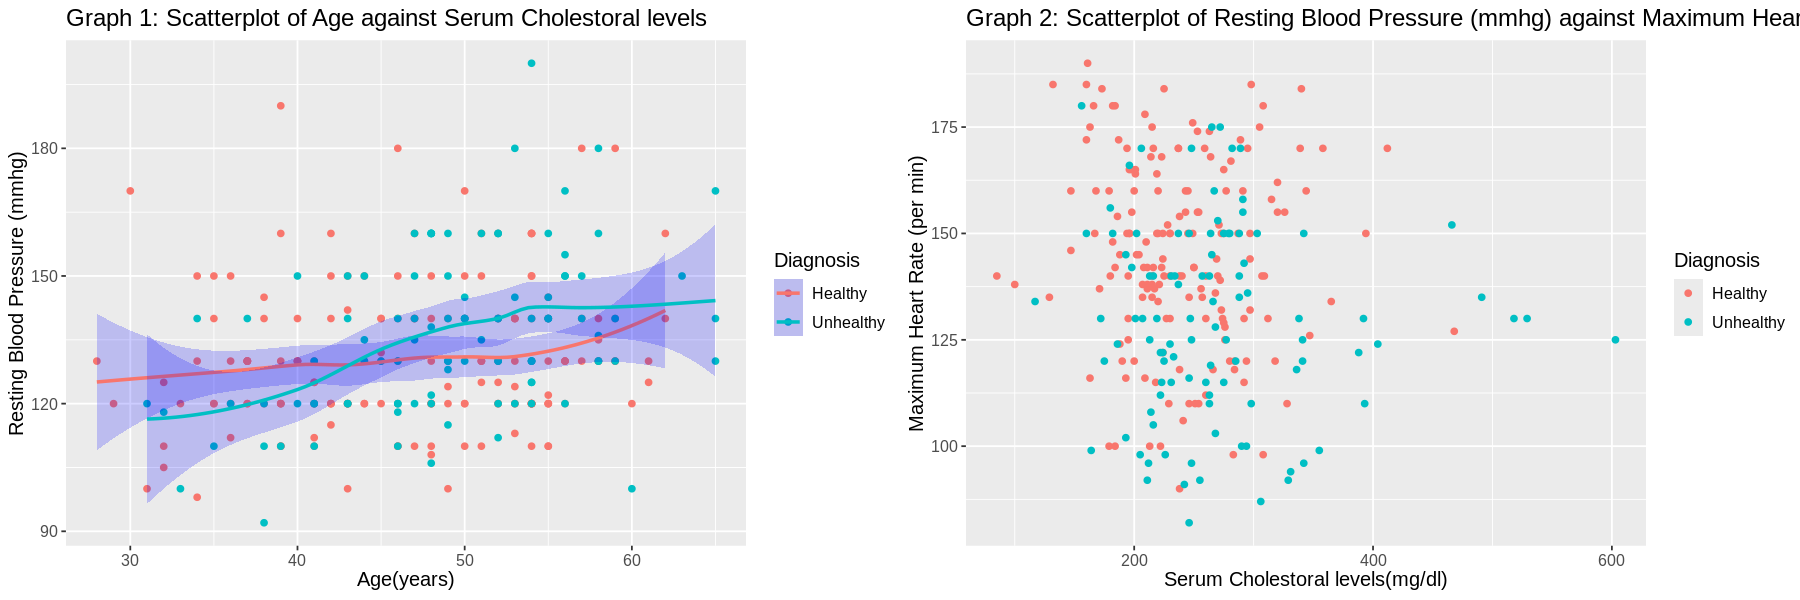

In [99]:
# create visualization of showing the distribution of Prognosis based on column that has high-variance in value 

library(ggplot2)
library(gridExtra)
options(repr.plot.width = 15, repr.plot.height = 5)

# Scatterplot for age variables and the resting blood pressure
plot_1 <- ggplot(process_hd_data, aes(x = age, y = trestbps, color = Diagnosis)) +
  geom_point(alpha=3) +
  labs(title = "Graph 1: Scatterplot of Age against Serum Cholestoral levels",
       x = "Age(years)", y = "Resting Blood Pressure (mmhg)", color = "Diagnosis") +
geom_smooth(method = "loess", fill = "blue", alpha = 0.2)+
  theme(text = element_text(size = 12))



# Scatterplot for cholestoral level variables and the maxium heart rate 
plot_2 <- ggplot(process_hd_data, aes(x = chol, y = thalach, color = Diagnosis)) +
  geom_point(alpha=3) +
  labs(title = "Graph 2: Scatterplot of Resting Blood Pressure (mmhg) against Maximum Heart Rate (per min)",
       x = "Serum Cholestoral levels(mg/dl)", y = "Maximum Heart Rate (per min)", color = "Diagnosis") +
  theme(text = element_text(size = 12))


grid.arrange(plot_1,plot_2, nrow = 1)


After producing multiple plots with the variables within our data, we found that resting bp, vs. age, and max heart rate vs. serum cholesterol levels gave us the most most visible and meaningful relationships. Within graph 1, we see how as age increases,not only does resting blood pressure increase, but there is a visible higher trend in increase of unhealthy diagnosis for heart disease, meaning the patient does have it. For graph 2, we can see that the lower the serum cholesterol levels are (which is the amount of total cholesterol in their blood), there is more healthy diagnosis, meaning the patient does not have heart disease, however as serum cholesterol levels increase, we can see more unhealthy diagnosis. 

In [100]:
#Prevent randomlization of data by setting seed number to a fixed number
set.seed(1234)

#Creating standardized recipe from training set
all_k_recipe <- recipe(Diagnosis ~ trestbps+thalach+age+chol+oldpeak , data = train_set) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# building the basic model specification to auto-tune k value
all_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# fold 10 times for cross-validation
all_k_vfold<- vfold_cv(train_set, v = 10, strata = Diagnosis)

kval <- tibble(neighbors = c(1:30))

# Workflow analysis for all k values from 1 to 30
all_k_results <- workflow() |>
      add_recipe(all_k_recipe) |>
      add_model(all_k_spec) |>
      tune_grid(resamples = all_k_vfold, grid = kval)|>
#collecting metrics and rank the k values based on their accuracy
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))
cat("Table 5: Highest model accuracy")
head(all_k_results)

Table 5: Highest model accuracy

neighbors,mean
<int>,<dbl>
21,0.7921053
22,0.7921053
23,0.7865497
24,0.7865497
17,0.7757310
18,0.7757310


Here we produced a standerdized recipe, then built our model specification in order to auto-tune the k value. In order to find the best K, we split the training set into a bunch of small sets (10), where 1/10th was used for testing, and 9/10 for training. A model was biult with the 9 training sets and evaluated against the 1 testing set. This process was repeated 10 times due to having 10 folds, using a different testing set each time. We then chose to test K values between 1-30, and then we collected the metrics to find which k value gave us the highest accuracy. 

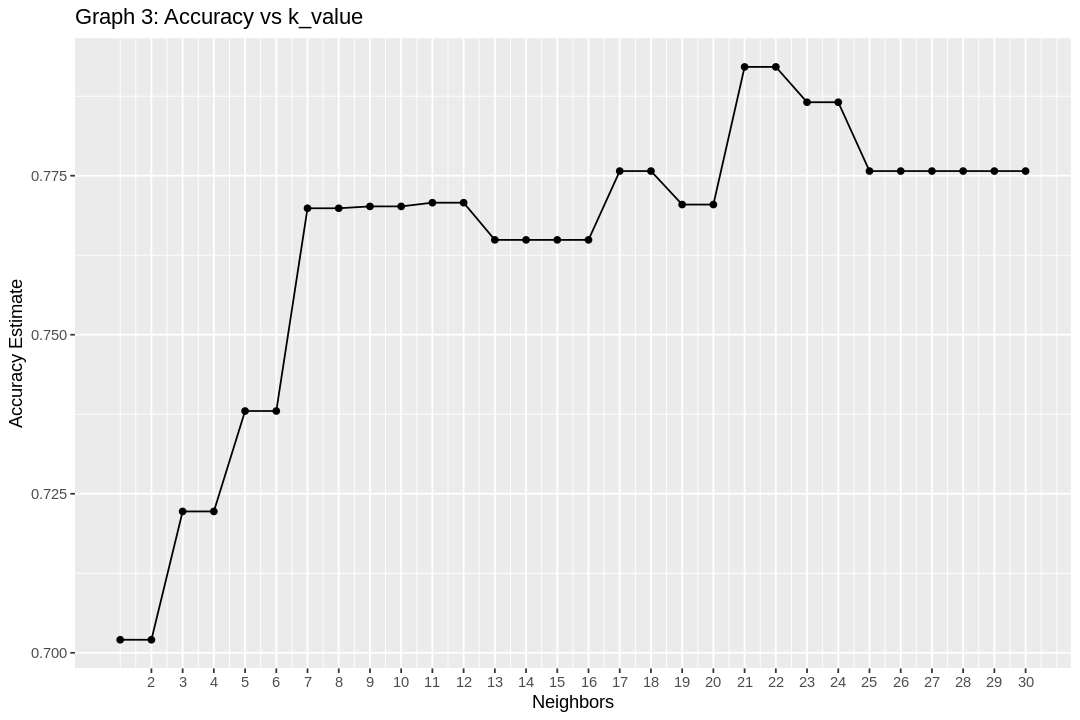

In [101]:
#ploting the K_Value vs Accuracy graph to show the relationship between number of k and its accuracy
k_val_plot <- 
       ggplot(all_k_results, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate",title="Graph 3: Accuracy vs k_value") +
       scale_x_continuous(breaks = seq(2, 30, by = 1))   
options(repr.plot.width = 9, repr.plot.height = 6)
k_val_plot

Producing the accuracy graph bettween the range we chose from 1-30 enables us to visually see which value of K gives us the highest accuracy. From here we can conclude the value is k = 21. 

In [102]:
# According to table, choose the best k where the accuracy is at most around 0.788
#verify
best_k <- all_k_results |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 21

In [103]:
#Use the best k_value which k=21 to build final model
best_k_spec<-nearest_neighbor(weight_func="rectangular", neighbors = best_k)|>
    set_engine("kknn")|>
    set_mode("classification")

best_k_workflow<-workflow()|>
    add_recipe(all_k_recipe)|>
    add_model(best_k_spec)|>
    fit(data = train_set)

cat("Table 6: Model Worflow")
best_k_workflow
    

Table 6: Model Worflow

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2180851
Best kernel: rectangular
Best k: 21

Now using our best k value we produced our workflow, given we made the final model with this best k of 21, and called it best_k_spec. 

In [113]:
#Apply our test set to the best_k_value model

set.seed(1234)


test_pred <- predict(best_k_workflow, test_set) |>
               bind_cols(test_set)



# Convert Diagnosis column to factor
test_pred$Diagnosis <- as.factor(test_pred$Diagnosis)




#Build metrics for precisions
result_matrics<- test_pred|>
    metrics(truth = Diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
#Build confusion matrics to show the truth table for Hungarian testing set


conf_mat<- test_pred |>
    conf_mat(truth = Diagnosis, estimate = .pred_class)
cat("Table 7: Confusion Matrix")
conf_mat

#Produce precision and recall table from out test_set result
recall1<-test_pred |>
    recall(truth = Diagnosis, estimate = .pred_class, event_level="second")


predictions1<-test_pred |>
    precision(truth = Diagnosis, estimate = .pred_class, event_level="second")

cat("\n\nlevels of diagnoses")
test_pred |> pull(Diagnosis) |> levels()

cat("\nTable 8: Recall, precision, and recall of the model")
combined_results <- bind_rows(recall1, predictions1, result_matrics)
combined_results

Table 7: Confusion Matrix

           Truth
Prediction  Healthy Unhealthy
  Healthy        48        20
  Unhealthy       3        11



levels of diagnoses

[1] "Healthy"   "Unhealthy"


Table 8: Recall, precision, and recall of the model

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.3548387
precision,binary,0.7857143
accuracy,binary,0.7195122


We then made our confusion matrix, along with making charts showing our accuracy, recall, and precision. We can see that our recall is very low, meaning that we missed identifying a large number of positive diagnosis from the data set. However, we have a relatively high precision, meaning out of the diagnosis that our classifier labelled as positive, 78% of those were actually positive (meaning people with diabetes).

Now in order to visualize the performance of our classifier, we produced a visualization of the confusion matrix: 

### Additional testing of the classifier:

In [118]:
#Testing model on cleveland data set

cle_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                      col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))

cat("Table 9: Cleveland Data Unfiltered")
head(cle_data)


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Table 9: Cleveland Data Unfiltered

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [119]:
#reprocess our data so that num column has class value of 0 and 1
new<-cle_data|>
mutate(num = ifelse(num != 0, 1, num))
cat("Table 10: Cleveland data with Added Diagnosis Coloumn")
head(new)

#Choosing the predicting variables that we are going to use to predict the class type(avoid using slop,ca,thl because they have missing values)
process_cl_data<-new|>
#choosing the predicting variables and class variable
select(c(age,chol,trestbps,thalach,oldpeak,num))|> 
#filter out any missing values
filter(age!="?",chol!="?",trestbps!="?",thalach!="?",oldpeak!="?",num!="?")|>
#change the type of the data to factor because the class variable we predicting should be categorical
mutate(num=as.factor(num))|>
#change the type of the data to dbl because the predicting variables we predicting should be double
mutate(across(c(age, chol, trestbps, thalach, oldpeak), as.integer))|>
#creating new column from num variable for better understanding about our classifier
mutate(Diagnosis= case_when(num == "0" ~ "Healthy",num == "1" ~ "Unhealthy"))
process_cl_data$oldpeak <- round(process_cl_data$oldpeak)
print(20)

cat("Table 11: Filtered Cleveland Data")
head(process_cl_data)

Table 10: Cleveland data with Added Diagnosis Coloumn

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


[1] 20
Table 11: Filtered Cleveland Data

age,chol,trestbps,thalach,oldpeak,num,Diagnosis
<int>,<int>,<int>,<int>,<dbl>,<fct>,<chr>
63,233,145,150,2,0,Healthy
67,286,160,108,1,1,Unhealthy
67,229,120,129,2,1,Unhealthy
37,250,130,187,3,0,Healthy
41,204,130,172,1,0,Healthy
56,236,120,178,0,0,Healthy


In order to test our classifier further, we decided to do extra work to test it on the cleveland data. Here we have preprocessed it, getting rid of any uknowns and adding our new Diagnosis column. Note that within this particular data frame, values 1,2,3, and 4 corresponded with a positive (unhealthy) diganoses, hence we began with reprocessing our data so we only had 0 (healthy), and 1 (unhealthy). 

In [120]:
#Apply hungarian data on cleveland data set

cle_pred <- predict(best_k_workflow, process_cl_data)|>
                      bind_cols(process_cl_data)

cat("Table 12: Predictions for Cleveland Data")
head(cle_pred)

# Convert Prognosis column to factor
cle_pred$Diagnosis <- as.factor(cle_pred$Diagnosis)


#Build metrics for accuracy
cle_matrics<- cle_pred|>
    metrics(truth = Diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

#Build confusion matrix to show the truth table for Cleveland dataset
cle_conf_mat<- cle_pred |>
    conf_mat(truth = Diagnosis, estimate = .pred_class)
cat("\n\nTable 13: Confusion Matrix")
cle_conf_mat

#Produce precision and recall table for better understanding
recall2<-cle_pred |>
    recall(truth = Diagnosis, estimate = .pred_class, event_level="second")


predictions2<-cle_pred |>
    precision(truth = Diagnosis, estimate = .pred_class, event_level="second")

cle_combined_results <- bind_rows(recall2, predictions2, cle_matrics)

cat("\n\nTable 14: Precision, Recall, and accuracy for the model")
cle_combined_results

Table 12: Predictions for Cleveland Data

.pred_class,age,chol,trestbps,thalach,oldpeak,num,Diagnosis
<fct>,<int>,<int>,<int>,<int>,<dbl>,<fct>,<chr>
Unhealthy,63,233,145,150,2,0,Healthy
Unhealthy,67,286,160,108,1,1,Unhealthy
Unhealthy,67,229,120,129,2,1,Unhealthy
Unhealthy,37,250,130,187,3,0,Healthy
Healthy,41,204,130,172,1,0,Healthy
Healthy,56,236,120,178,0,0,Healthy




Table 13: Confusion Matrix

           Truth
Prediction  Healthy Unhealthy
  Healthy       156        82
  Unhealthy       8        57



Table 14: Precision, Recall, and accuracy for the model

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.4100719
precision,binary,0.8769231
accuracy,binary,0.7029703


What we have done here is made predictions based off of our classifier on the cleveland data, and ultimately made a confusion matrix to then find the values for the recall, precision, and accuracy. 

## Discussion: 

## References: